
# Feature Engineering

This notebook derives predictive features from the aggregated monthly dataset (`sales_tableau.csv`).  Lag features, rolling averages, calendar indicators and promotional/price signals are constructed to support machine learning models.  A correlation matrix highlights relationships between variables, and a simple XGBoost model provides an initial view of feature importances.


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error

agg_path = Path('..') / 'data' / 'processed' / 'sales_tableau.csv'
df = pd.read_csv(agg_path, parse_dates=['month'])
print('Aggregated shape:', df.shape)
df.head()


Aggregated shape: (38934, 9)


,month,product_id,product_name,atc_code,region,total_units,total_sales,avg_unit_price,promo_days
0,2020-01-01,GEN-45,Generic Painkiller 45,N02BE/B,East Midlands,29,98.51,3.310000,0
1,2020-01-01,GEN-45,Generic Painkiller 45,N02BE/B,East of England,16,56.46,3.515000,0
2,2020-01-01,GEN-45,Generic Painkiller 45,N02BE/B,London,33,115.96,3.468000,1
3,2020-01-01,GEN-45,Generic Painkiller 45,N02BE/B,North East,43,141.98,3.340769,2
4,2020-01-01,GEN-45,Generic Painkiller 45,N02BE/B,North West,11,35.13,3.227500,0


In [2]:

df = df.sort_values(['product_id','month'])

for lag in [1,3,6]:
    df[f'lag_{lag}'] = df.groupby('product_id')['total_sales'].shift(lag)

for window in [3,6]:
    df[f'rolling_{window}'] = (
        df.groupby('product_id')['total_sales']
        .shift(1)
        .rolling(window)
        .mean()
        .reset_index(0, drop=True)
    )

df['month_num'] = df['month'].dt.month
df['year'] = df['month'].dt.year

feature_cols = ['lag_1','lag_3','lag_6','rolling_3','rolling_6','promo_days','avg_unit_price','month_num','year']

df_features = df.dropna(subset=feature_cols + ['total_sales']).copy()

print('Feature table shape:', df_features.shape)
df_features.head()


Feature table shape: (38166, 16)


,month,product_id,product_name,atc_code,region,total_units,total_sales,avg_unit_price,promo_days,lag_1,lag_3,lag_6,rolling_3,rolling_6,month_num,year
6,2020-01-01,GEN-45,Generic Painkiller 45,N02BE/B,South East,46,160.27,3.481429,0,100.35,141.98,98.51,92.486667,91.398333,1,2020
7,2020-01-01,GEN-45,Generic Painkiller 45,N02BE/B,South West,41,135.40,3.380667,1,160.27,35.13,56.46,98.583333,101.691667,1,2020
8,2020-01-01,GEN-45,Generic Painkiller 45,N02BE/B,West Midlands,37,134.41,3.569091,0,135.40,100.35,115.96,132.006667,114.848333,1,2020
9,2020-01-01,GEN-45,Generic Painkiller 45,N02BE/B,Yorkshire & Humber,17,53.58,3.267143,1,134.41,160.27,141.98,143.360000,117.923333,1,2020
649,2020-02-01,GEN-45,Generic Painkiller 45,N02BE/B,East Midlands,31,110.08,3.482308,2,53.58,135.40,35.13,85.143333,88.706667,2,2020


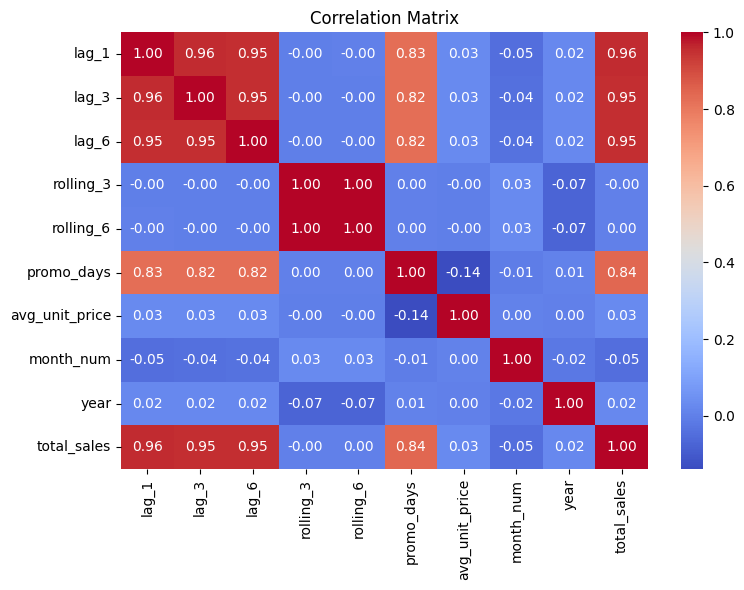

In [3]:

corr = df_features[feature_cols + ['total_sales']].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()



The correlation matrix shows strong positive relationships between the lagged/rolling features and the target `total_sales`, as expected. Price (`avg_unit_price`) and promotions (`promo_days`) exhibit weaker but still meaningful correlations.


Test MAPE: 50.88%


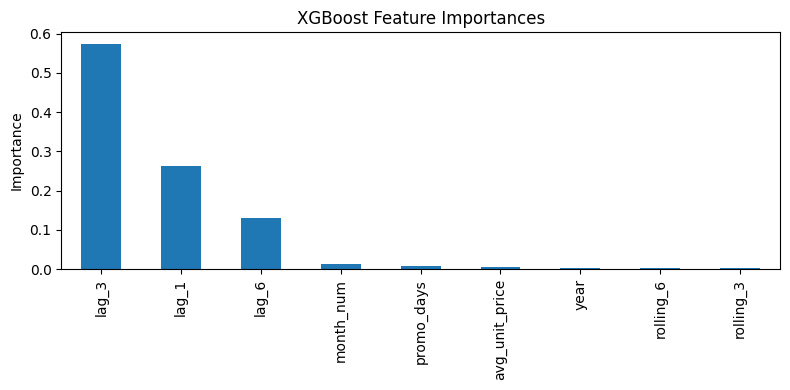

In [4]:

# Train/test split (time ordered)
X = df_features[feature_cols]
y = df_features['total_sales']

split_idx = int(len(df_features) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42)
model.fit(X_train, y_train)

preds = model.predict(X_test)
mape = mean_absolute_percentage_error(y_test, preds)
print(f"Test MAPE: {mape:.2%}")

importances = pd.Series(model.feature_importances_, index=feature_cols).sort_values(ascending=False)

plt.figure(figsize=(8,4))
importances.plot(kind='bar')
plt.title('XGBoost Feature Importances')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()



The feature importance plot suggests that recent sales history (lags and rolling means) are the most predictive inputs. Promotional activity and price also contribute, but to a lesser extent. Calendar variables (month and year) capture seasonality and long‑term growth.
